# Credit Card Customer Segmentation

![](https://www.cloudresearch.com/wp-content/uploads/2020/02/graph.png)

Image Source: [Cloud Reseach](https://www.cloudresearch.com/resources/guides/market-segmentation/case-study-mastercard/)

## Table of Contents
---
- [Introduction](#Introduction)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Engineering](#Feature-Engineering)
- [Scaling the Data](#Scaling-the-Data)
- [Choosing K](#Choosing-K)
- [Analyzing Results](#Analyzing-Results)
- [Conclusions](#Conclusions)

## Introduction

In this scenario, we’ll play the role of a data scientist working for a credit card company. We’ve been given a dataset containing information about the company’s clients and asked to help segment them into different groups in order to apply different business strategies for each type of customer.

The company expects to receive a group for each client and also an explanation of the characteristics of each group and what are the main points that make them different. In a planning meeting with the Data Science coordinator, it was decided that we should use the K-means algorithm to segment the data.

In order to use the algorithm properly and achieve all the goals that the company has set for us, we'll go through the following steps:

- Analyze the dataset.
- Prepare the data for modeling.
- Find an appropriate number of clusters.
- Segment the data.
- Interpret and explain the results.

Below are the features of the dataset:

- `customer_id`: unique identifier for each customer.
- `age`: customer age in years.
- `gender`: customer gender (M or F).
- `dependent_count`: number of dependents of each customer.
- `education_level`: level of education ("High School", "Graduate", etc.).
- `marital_status`: marital status ("Single", "Married", etc.).
- `estimated_income`: the estimated income for the customer projected by the data science team.
- `months_on_book`: time as a customer in months.
- `total_relationship_count`: number of times the customer contacted the company.
- `months_inactive_12_mon`: number of months the customer did not use the credit card in the last 12 months.
- `credit_limit`: customer's credit limit.
- `total_trans_amount`: the overall amount of money spent on the card by the customer.
- `total_trans_count`: the overall number of times the customer used the card.
- `avg_utilization_ratio`: daily average utilization ratio.

We'll start by importing the packages we'll use.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

np.random.seed(42)

sns.set_style('whitegrid')
%matplotlib inline

## Exploratory Data Analysis

After reading the data into pandas, it's time to explore it. Let's investigate the size of the dataset, what columns it contains, the type of values in each column, and also check on missing values.

In [2]:
customers = pd.read_csv('customer_segmentation.csv')
customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [3]:
customers.shape

(10127, 14)

In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

There are 10127 rows and 14 columns in the dataset including a unique identifier (`customer_id`) for each client which we won't use for segmentation. Of the 13 remaining columns, there are 8 columns containing integers, 2 containing floats, and 3 columns containing strings, which means we have 3 categorical columns to deal with.

Also, there are no missing values. We will now visualize the gender, level of education, and maritial status of our customers.

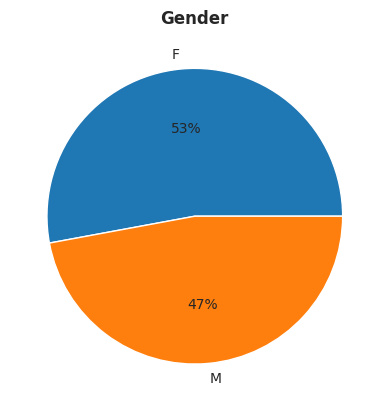

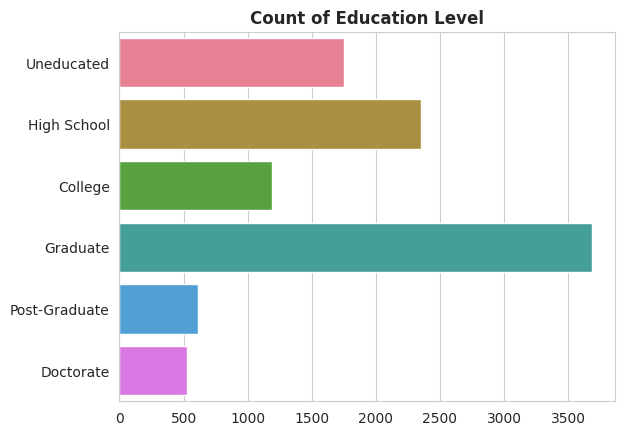

Text(0, 0.5, '')

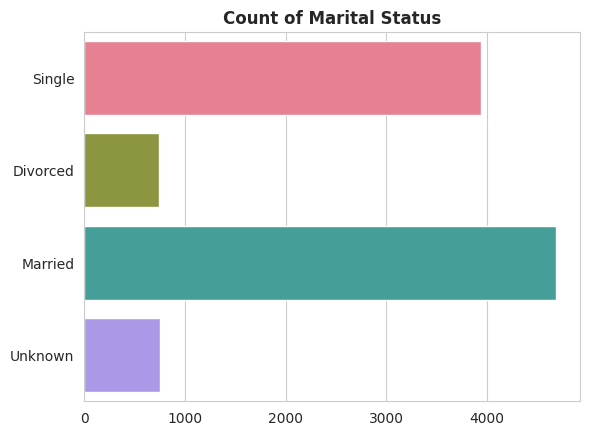

In [5]:
order=['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate']

# Visualize genders using a pie plot
customers['gender'].value_counts(normalize=True).plot.pie(autopct='%1.0f%%')
plt.title('Gender', weight = 'bold')
plt.xlabel('')
plt.ylabel('')
plt.show()

# Visualize education levels with a bar plot
sns.countplot(data=customers, y='education_level', order=order, orient='h',palette=sns.color_palette("husl", 6))
plt.title('Count of Education Level', weight='bold')
plt.xlabel('')
plt.ylabel('')
plt.show()

# Visualize maritial status with a bar plot
order=['Single', 'Divorced', 'Married', 'Unknown']
sns.countplot(data=customers, y='marital_status', order=order,orient='h',palette=sns.color_palette("husl", 4))
plt.title('Count of Marital Status', weight='bold')
plt.xlabel('')
plt.ylabel('')

As we're working with an unsupervised machine learning algorithm (K-means), there isn't a target variable on which we can measure the impacts of the other variables. However, we can see the correlation between the numeric variables and their distributions.

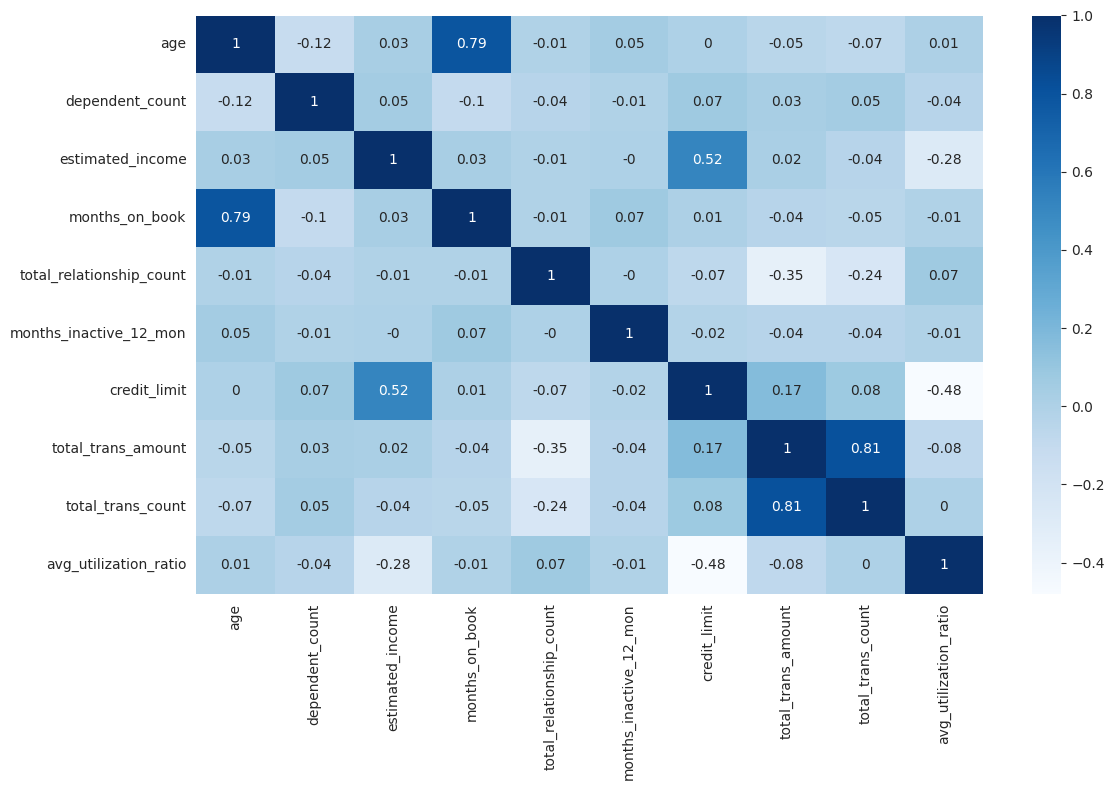

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(round(customers.drop('customer_id', axis=1).corr(), 2), cmap='Blues', annot=True, ax=ax)

plt.tight_layout()
plt.show()

Most of the variables present weak correlations between each other, but there are some we can highlight:

- `Age` is strongly correlated with how long the person has been a customer (`months_on_book`)
- `Credit limit` is positively correlated with `estimated income` and negatively correlated with `average utilization ratio`
- The total number of transactions (`total_trans_count`) is strongly correlated with the total amount transitioned (`total_trans_amount`)

We will now create subplots of the 10 numerical columns.

/tmp/ipykernel_12298/4252282034.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  customers.drop('customer_id', axis=1).hist(ax=ax)


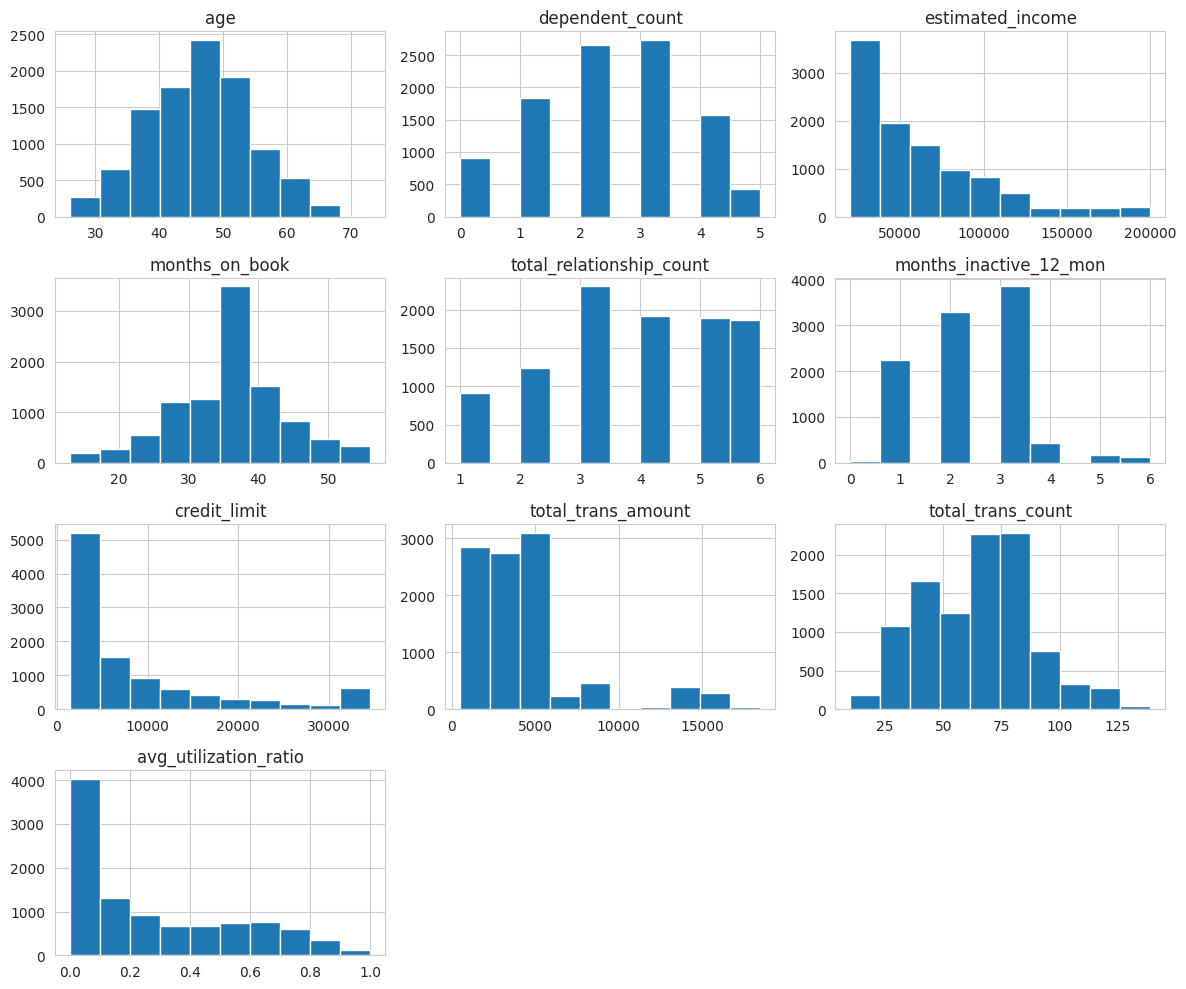

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))

#Removing the customer's id before plotting the distributions
customers.drop('customer_id', axis=1).hist(ax=ax)

plt.tight_layout()
plt.show()

The ten numerical columns have distributions resembling normal distributions and some that are right skewed.

## Feature Engineering 

Let's start dealing with the categorical columns. There are three of them: `gender`, `education_level`, and `marital_status`.

The `gender` column is the easiest one. We'll use a lambda function to replace the values with ones and zeros.

We'll also be able to transform the `education_level` column to numeric. We'll use the `replace()` method to perform this task. This method will assign a value to each level of education:

- `Uneducated - 0`
- `High School - 1`
- `College - 2`
- `Graduate - 3`
- `Post-Graduate - 4`
- `Doctorate - 5`

Unfortunately, we can't do the same for this `marital_status` column as there is no level of magnitude between "Single", "Married" or "Divorced", for example. We can't say that any of them is higher or better than the others. Therefore, we'll use one-hot-encoding to create dummy variables from this column and then drop the original variable.

In [8]:
# Copy the customers dataframe and change gender to numerical values
customers_modif = customers.copy()
customers_modif['gender'] = customers['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [9]:
# Order the 6 unique values in the education level column
customers_modif.replace(to_replace={'Uneducated': 0, 'High School': 1, 'College':2,
                                    'Graduate': 3, 'Post-Graduate': 4, 'Doctorate':5}, inplace=True)

In [10]:
# Use one-hot-encoding to create dummy variables for the maritial status column.
dummies = pd.get_dummies(customers_modif[['marital_status']], drop_first=True)

customers_modif = pd.concat([customers_modif, dummies], axis=1)
customers_modif.drop(['marital_status'], axis=1, inplace=True)

print(customers_modif.shape)
customers_modif.head()

(10127, 16)


,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0


## Scaling the Data

We have different scaled data across the DataFrame. The `estimated_income`, for instance, contains numbers in the range of dozens and hundreds of thousands, while the `dependent_count` column contains numbers from 1 to 5.

We'll use scikit-learn's `StandardScaler()` to make the data have the same scale.

In [11]:
# Scale the DataFrame without the `customer_id` field
X = customers_modif.drop(['customer_id'], axis=1)
scaler = StandardScaler()
scaler.fit(X)

# Transform the data and turn the resulting array back into a Dataframe
X_scaled = scaler.transform(X)
X = pd.DataFrame(X_scaled)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.165406,1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,1.077338,-0.798507,-0.282609
1,0.333570,-0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,-0.928214,1.252337,-0.282609
2,0.583058,1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,1.077338,-0.798507,-0.282609
3,-0.789126,-0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,-0.928214,-0.798507,3.538459
4,-0.789126,1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,1.077338,-0.798507,-0.282609


## Choosing K

Now our dataset is ready for machine learning. The next step is to decide the best number of clusters to use in the segmentation according to the inertia metric.

We'll run the k-means algorithm considering a range from 1 to 10 possible Ks and store the results. Then, we'll plot the elbow curve that will help us find a reasonable choice for K.

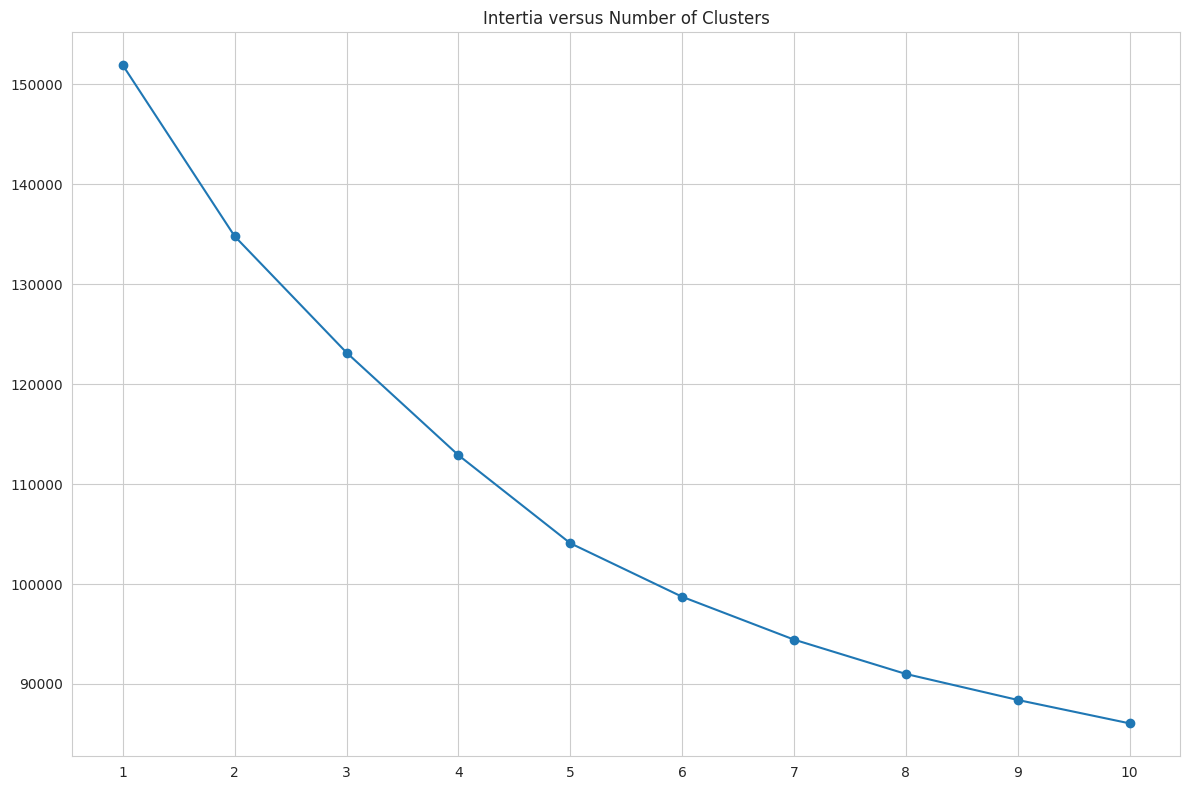

In [12]:
inertias = []

# Loop through from 1 to 10 to find the optimal K
for k in range(1,11):
    model = KMeans(n_clusters=k)
    y = model.fit_predict(X)
    inertias.append(model.inertia_)

# Plot the elbow curve
plt.figure(figsize=(12,8))
plt.plot(range(1,11), inertias, marker='o')
plt.xticks(ticks=range(1,11), labels=range(1,11))
plt.title("Intertia versus Number of Clusters")

plt.tight_layout()
plt.show()
    

The inertia decreases more slowly between 5 and 7 clusters. We'll use 6 clusters.

In [13]:
model = KMeans(n_clusters=6)
y = model.fit_predict(X_scaled)

## Analyzing Results

All that's left is to analyze the results. We will see how the variables used in the clusterization differ from cluster to cluster in order better explain what each cluster represents.

We will first create a `CLUSTER` column in our original DataFrame so we can better understand the characteristics of each cluster.

In [14]:
customers['CLUSTER'] = y + 1
customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,CLUSTER
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,4
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,6
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,4
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,3
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,2


In [15]:
customers['CLUSTER'].value_counts()

2    2790
6    2480
4    1785
5    1427
1     911
3     734
Name: CLUSTER, dtype: int64

We can see that cluster 2 is the largest while cluster 3 is the smallest.

For the numeric variables, we'll check the average value of each variable per cluster. We will need to group the data and plot a bar chart for every column.

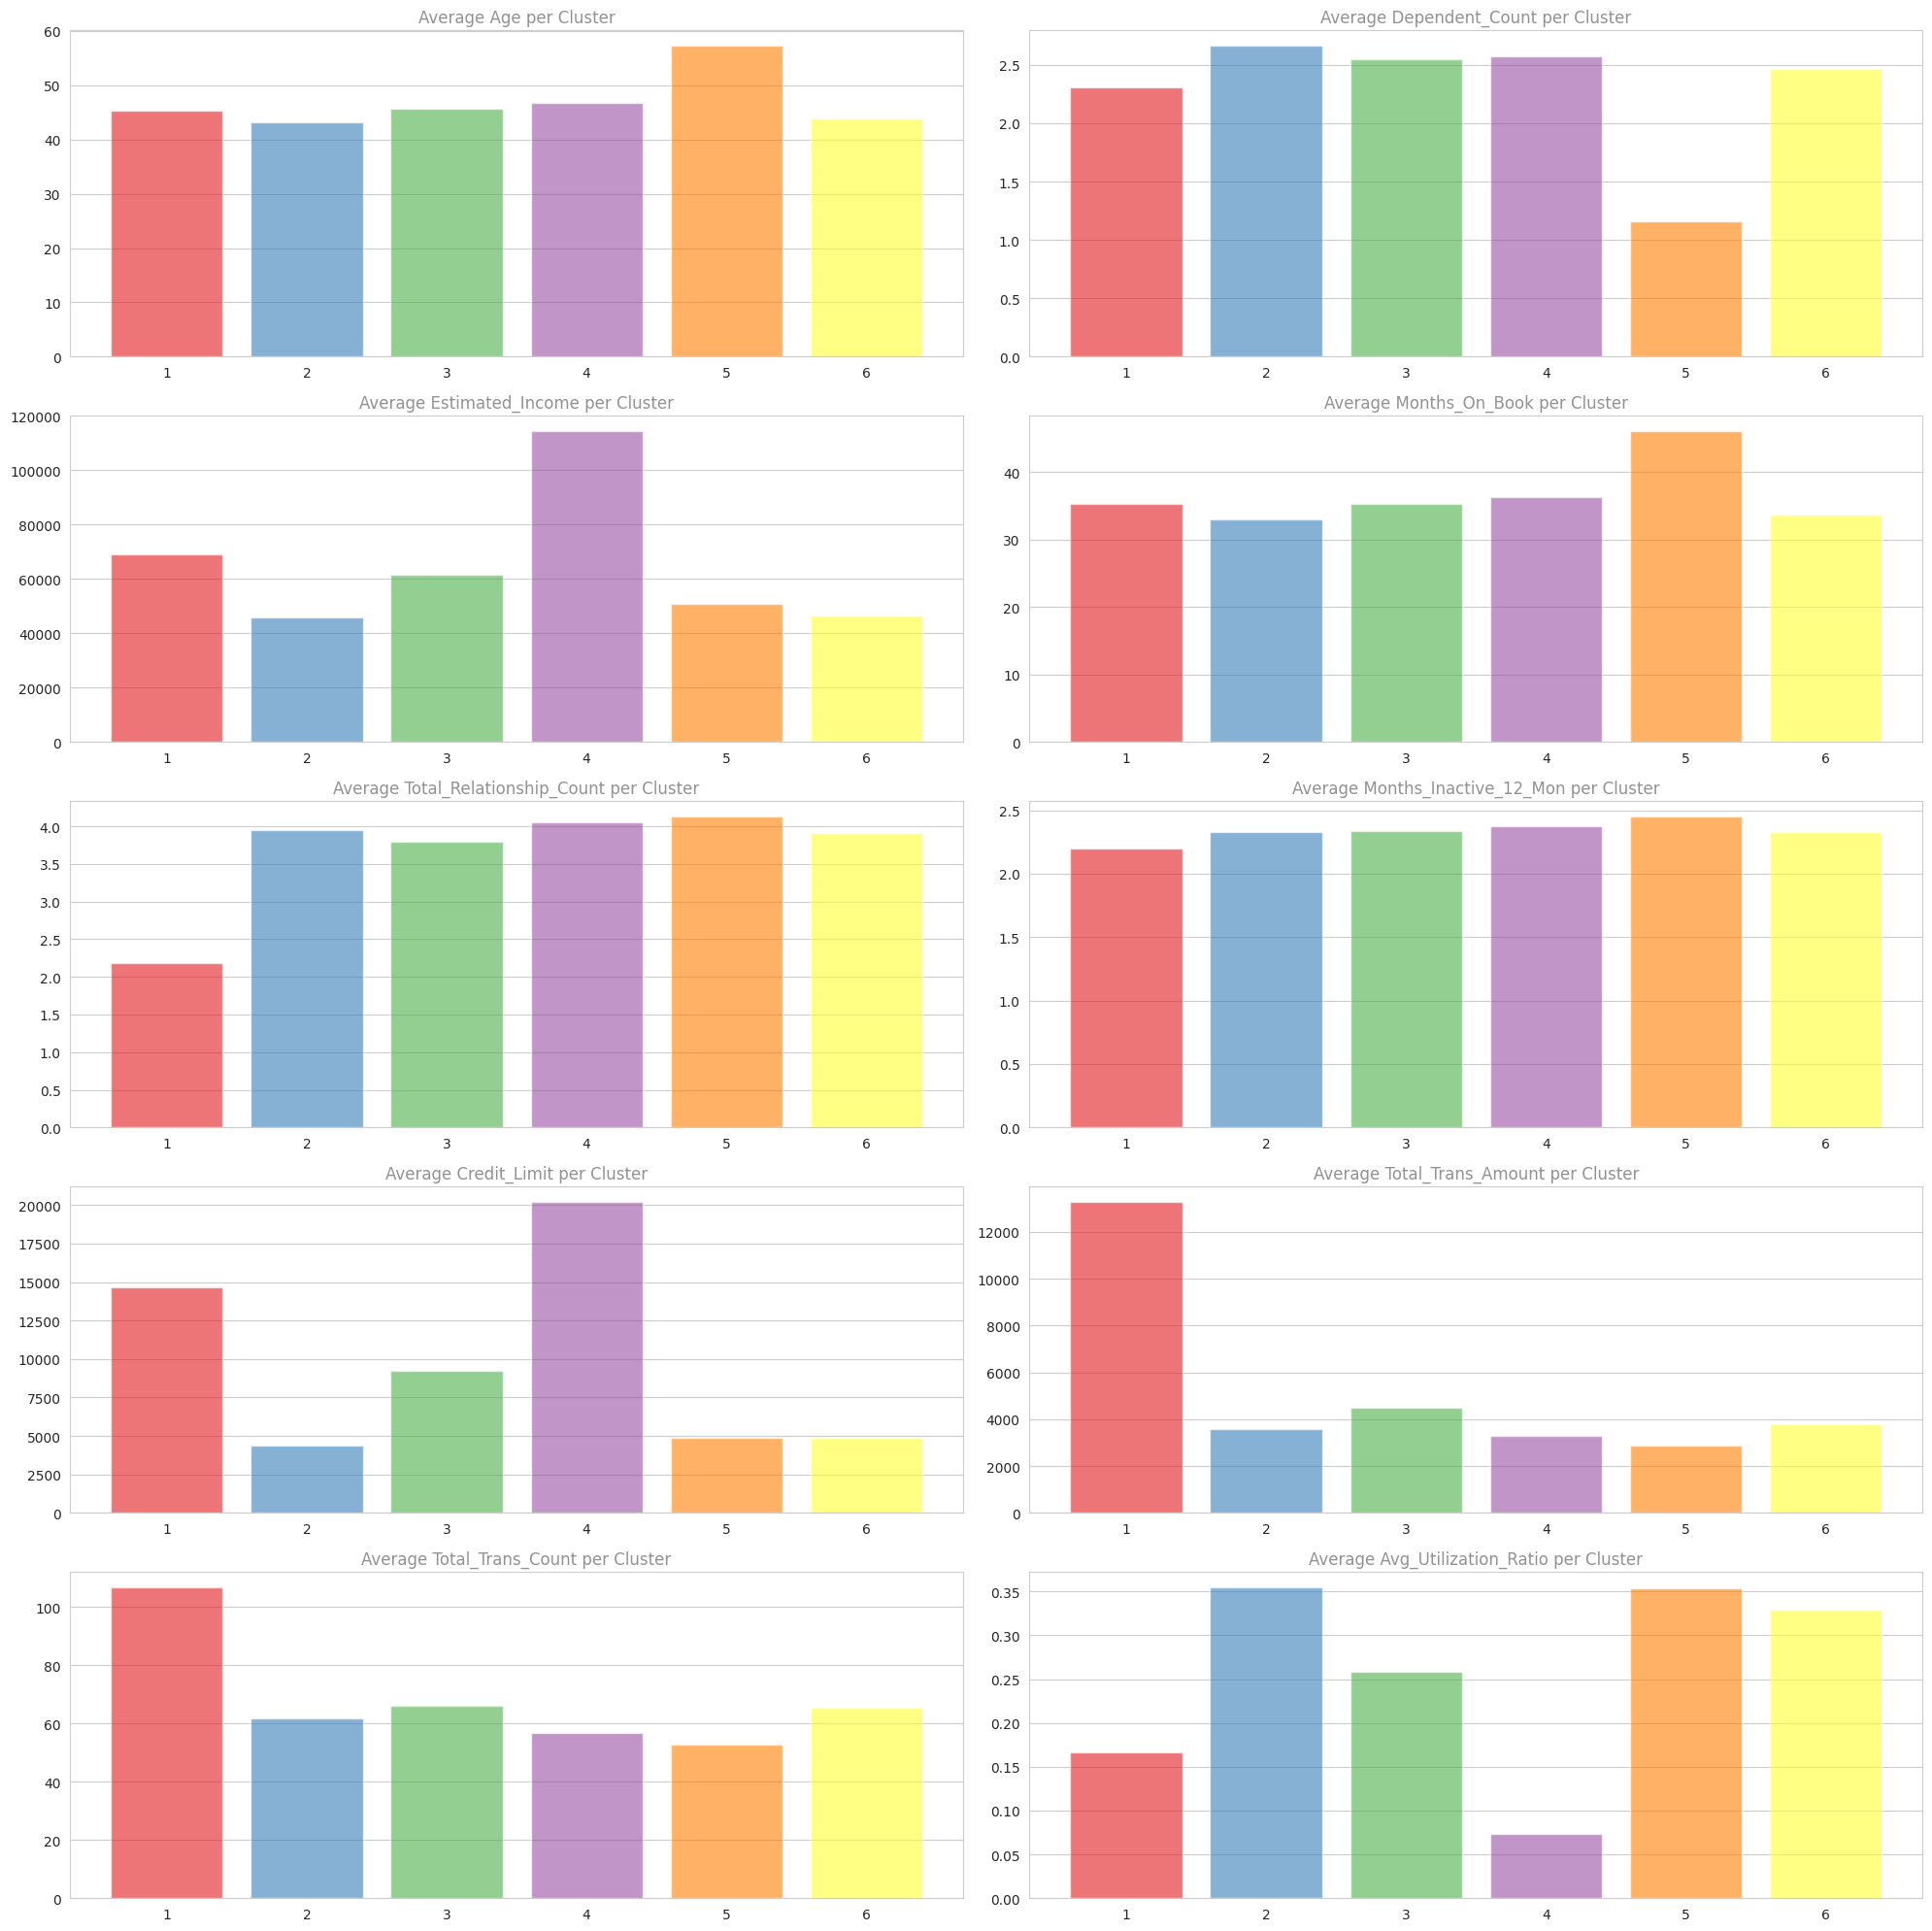

In [16]:
numeric_columns = customers.select_dtypes(include=np.number).drop(['customer_id', 'CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

For numerical variables with high correlation, we can use a scatter plot to visualize the correlation grouped by clusters and then analyze how the clusters change different parts of the scatter plot.

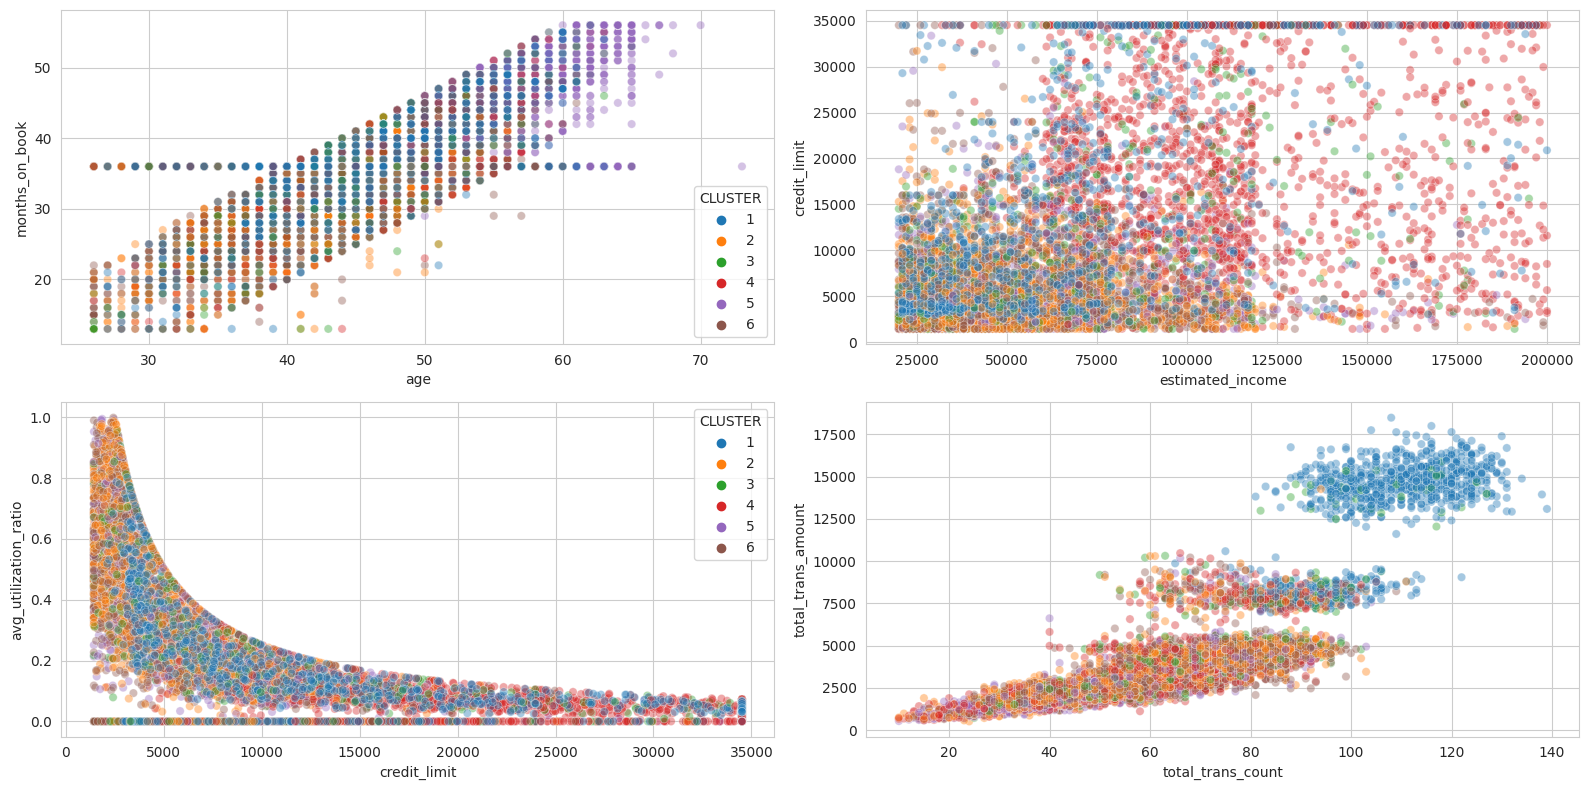

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()

We can draw some conclusions with the numeric variables.

For example, cluster 1 has the highest amount of money transitioned, while cluster 2 has the lowest credit limit and estimated income and the highest utilization rate. Cluster 4 has the highest credit limit. Older clients are grouped in cluster 5.

For the categorical columns, we'll plot the percentile distribution of each variable in each cluster. This will allow us to verify if a particular cluster is mostly composed of men, women, or of married people only.

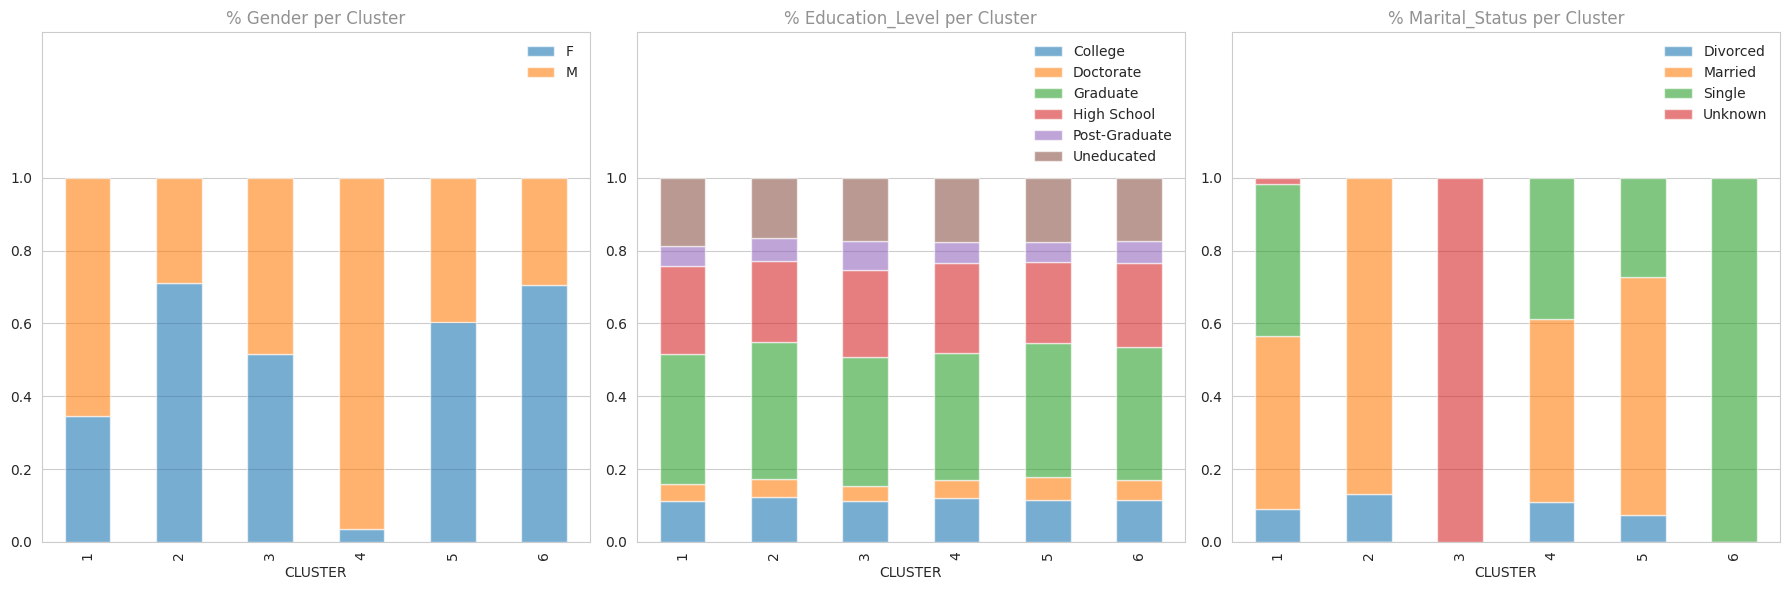

In [18]:
# Creating a stacked bar chart
cat_columns = customers.select_dtypes(include=['object'])

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(cat_columns):
    plot_df = pd.crosstab(index=customers['CLUSTER'], columns=customers[col], values=customers[col], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {col.title()} per Cluster', alpha=0.5)

    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)
    
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax.yaxis.set_ticks(labels)

plt.tight_layout()
plt.show()

For the categorical variables, we notice that the education level is well seperated between clusters.

On the other hand, cluster 2 is composed almost entirely of married people, while we don't know the marital status of anybody in cluster 3. Cluster 4 is almost completely male and Cluster 6 is purely single people.

## Conclusions

As demanded by the company, we now have listed the most important characteristics of each cluster. We could also provide some suggestions and insights into all of them.

In the end, we have the list of customers with a cluster assigned to each one.

### Cluster 1 

**Characteristics**: Mostly men; high credit limit; high amount transitioned; high number of transactions; low utilization rate. 

**Insight**: People with high volume spent on the card, but do not use it on a daily basis. Could be incentivised to spend more. 

### Cluster 2 

**Characteristics**: Mostly women;  mostly married; low estimated income; low credit limit; low amount transitioned; high utilization rate.

**Insight**: Married people (majority women) with low income and limit but utilize too much of their credit with a few larger purchases

### Cluster 3

**Cluster 3**: Gender well divided; low credit limit, high utilization rate; marital status 100% unknown; smaller cluster.

**Insight**: Men and women with low credit limits but do have high balances.

### Cluster 4

**Cluster 4**: Mostly men, mostly single and married, high estimated income, high credit limit; low amount transitioned; low utilization rate.

**Insight**: People (majority men) with high income and credit limits, but don't use the card. Could be incentivized to use it.

### Cluster 5

**Cluster 5**: Mostly married, high age, low dependent count, long time customers, low credit limit, low amount transitioned, high utilization rate.

**Insight**: Older people and long-time customers. Low credit limit and transactions, but use the card very often. Could receive benefits to spend more money.

### Cluster 6

**Cluster 6**: Mostly women; 100% single people, low estimated income, low credit limit, low amount transitioned, high utilization rate.

**Insight**: Single (mostly women) people that use their card a lot but have low credit limits and income. Could be given a bit more credit limit.